In [7]:
import pandas as pd
import numpy as np
import torch

In [8]:
ml1m_dir = '/data/vnkljukin/train.csv'
ml1m_rating = pd.read_csv(ml1m_dir)
ml1m_rating.rating += 1
ml1m_rating.rating //= 2
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
# Test
test_dir = '/data/vnkljukin/solution.csv'
test_rating = pd.read_csv(test_dir)
test_rating.rating += 1
test_rating.rating //= 2

Range of userId is [0, 42976]
Range of itemId is [0, 328049]


In [9]:
from bert_cnn import BertCNN
from utils import resume_checkpoint

In [10]:
config = {'alias': 'bert_conv_outer_simple_5',
           'num_epoch': 200,
           'batch_size': 2048,
           'optimizer': 'adam',
           'adam_lr': 1e-3,
           'num_users': 42977,
           'num_items': 328050,
           'latent_dim': 64,
           'l2_regularization': 0.,
           'use_cuda': True,
           'device_id': 0,
           'pretrain': False,
           'title_embeddings': '/data/vnkljukin/encoded_bert_128.npy',
           'content_embeddings': None,
           'model_dir': '/data/vnkljukin/checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
           }

In [11]:
bert_cnn = BertCNN(config)
resume_checkpoint(bert_cnn, 
                  '/data/vnkljukin/checkpoints/bert_conv_outer_simple_4_Epoch2_HR0.1862_NDCG0.1952.model', 
                  config['device_id'])

In [33]:
ml1m_rating[ml1m_rating.rating == 0]

,userId,itemId,rating
0,0,206495,0
1,0,279694,0
2,0,19718,0
3,0,74707,0
4,0,221548,0
...,...,...,...
67780163,42976,110624,0
67780164,42976,228542,0
67780165,42976,221362,0
67780166,42976,174323,0


In [46]:
embedding_user = bert_cnn.embedding_user(torch.LongTensor([0]))[0]
embedding_user

tensor([-0.1717,  0.8446, -1.4469, -0.3326,  0.7919, -0.0136, -0.4142, -1.6324,
         0.9632, -1.3776,  0.9781, -0.6464,  1.5389, -0.6001,  0.3175,  1.5729,
        -0.3469,  0.7728, -1.0348,  0.2080,  0.3602, -0.8120,  0.6954,  1.2429,
        -0.0515, -3.1168, -0.0033,  0.7668, -0.7742, -2.2568, -0.9312, -0.3206,
        -0.5102,  0.7581, -1.8322, -0.3268,  0.0696,  1.3459,  1.5709,  0.4434,
         1.6173,  2.0309, -1.2552, -0.5256, -0.6336,  1.0230, -0.3462,  1.0497,
         1.2333,  0.2300, -2.0639,  1.6461,  1.0516,  0.9886,  0.8512,  1.8918,
         0.9129,  0.3340,  0.4865,  0.8359,  1.2063, -1.5758,  1.2167,  0.0328],
       grad_fn=<SelectBackward>)

In [47]:
embedding_item = bert_cnn.item_title(torch.LongTensor([93250]))[0]
embedding_item

tensor([-0.8719,  1.1985, -0.5607,  0.9447,  0.0925, -0.0874,  1.1904,  0.5631,
         1.2309,  1.3596, -0.3879, -0.5028, -0.6219, -0.4787, -0.2760,  1.0199,
         1.0564,  1.0361,  1.8947,  0.1679, -0.7073, -1.4156,  1.3739, -0.7428,
        -1.8705,  0.8361, -1.2331, -0.3459, -0.9374,  3.0337, -0.2374,  2.0981,
        -0.5362,  0.4623,  0.0043, -0.2752,  0.5095, -0.3886, -0.2474, -0.7064,
         0.2939, -0.1585,  0.2723,  1.0128, -0.3277, -0.1618,  1.5827, -3.7812,
         1.1094, -0.2677,  0.3876, -0.3315,  0.4665, -0.4870,  1.1223, -1.2605,
         0.7065, -0.8935,  0.6630, -2.9425, -0.2666, -2.5316,  0.6551, -2.5473,
        -0.9798,  1.4223, -0.1584, -0.3281,  1.8058, -1.0935, -0.7682, -0.1708,
         0.8377, -1.6991,  0.1029,  1.6448,  1.8769,  1.5753, -1.1068, -0.8172,
         0.6123, -0.5178, -0.5431,  0.2460,  0.3630,  1.4030,  0.0599,  0.1597,
        -0.0236,  0.0479, -0.7968, -1.2506,  1.5025, -0.6528, -0.9517, -0.5562,
        -0.2188, -0.1381, -0.0210, -0.09

In [44]:
bert_cnn.eval()
bert_cnn(torch.LongTensor([0]), torch.LongTensor([93250]))

tensor([[0.5453]], grad_fn=<SigmoidBackward>)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

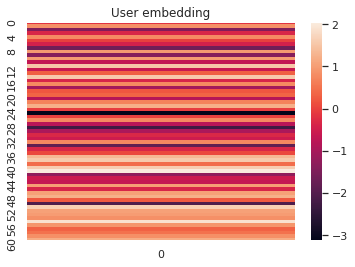

In [26]:
plt.title('User embedding')
sns.heatmap(embedding_user.detach().numpy().reshape(-1, 1))
plt.show()

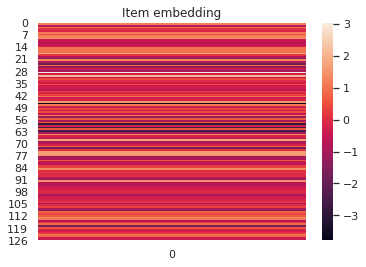

In [27]:
plt.title('Item embedding')
sns.heatmap(embedding_item.detach().numpy().reshape(-1, 1))
plt.show()

In [48]:
outer_map_pos = embedding_user.detach().numpy().reshape(-1, 1) @ embedding_item.detach().numpy().reshape(1, -1)
outer_map_pos.shape

(64, 128)

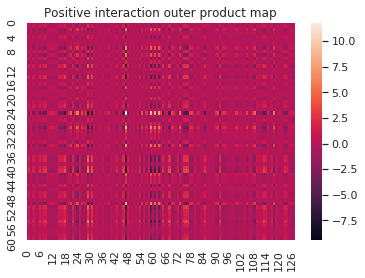

In [43]:
plt.title('Positive interaction outer product map')
sns.heatmap(outer_map)
plt.show()

In [49]:
embedding_user = bert_cnn.embedding_user(torch.LongTensor([0]))[0]
embedding_item = bert_cnn.item_title(torch.LongTensor([221548]))[0]
outer_map_neg = embedding_user.detach().numpy().reshape(-1, 1) @ embedding_item.detach().numpy().reshape(1, -1)

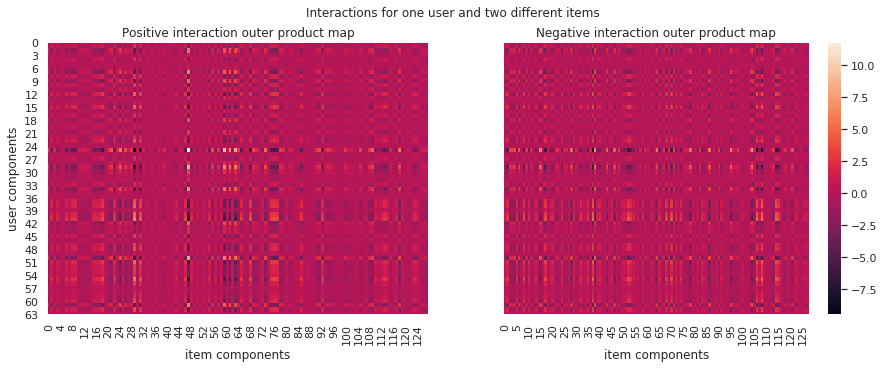

In [77]:
vmin = min(outer_map_neg.min(), outer_map_pos.min())
vmax = max(outer_map_neg.max(), outer_map_pos.max())

plt.figure(figsize=(15, 5))
plt.suptitle('Interactions for one user and two different items')
plt.subplot(1, 2, 1)
plt.title('Positive interaction outer product map')
sns.heatmap(outer_map_pos, vmin=vmin, vmax=vmax, cbar=False)
plt.ylabel('user components')
plt.xlabel('item components')

plt.subplot(1, 2, 2)
plt.title('Negative interaction outer product map')
g2 = sns.heatmap(outer_map_neg, vmin=vmin, vmax=vmax)
g2.set_yticks([])
plt.xlabel('item components')
plt.savefig('/data/vnkljukin/outer_maps.png')
plt.show()